# Planning observations with `astroplan`

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.time import Time
import pytz

from astroplan.plots import plot_airmass
from astroplan import Observer, FixedTarget, time_grid_from_range

---

# Time and Dates
- ### All dates and times in are UTC: *Coordinated Universal Time*
- All `Time` calculation assume that the time is UTC.
- UTC is related to  Greenwich Mean Time (GMT) but does not change with a change of seasons.
- Time will default to 00:00:00 UTC.

In [2]:
my_date = Time("2020-02-19")

my_date

<Time object: scale='utc' format='iso' value=2020-02-19 00:00:00.000>

In [3]:
my_date.iso

'2020-02-19 00:00:00.000'

In [4]:
f"The value of my_date is {my_date.iso}"

'The value of my_date is 2020-02-19 00:00:00.000'

### Different Date Formats

In [5]:
print(f"The Julian Date is {my_date.jd:.2f}")

print(f"The Modified Julian Date is {my_date.mjd:.2f}")

print(f"The unix Epoch is {my_date.unix:.2f}")  # Seconds since (Jan 01, 1970 00:00:00 UTC)

print(f"The fraction of a year is {my_date.decimalyear:.2f}")

The Julian Date is 2458898.50
The Modified Julian Date is 58898.00
The unix Epoch is 1582070400.00
The fraction of a year is 2020.13


---

### [Accurate Time](http://bmmorris.blogspot.com/2015/06/ut1-utc-and-astropy.html) - `UT1`

* `AstroPy` calculates the times of events to a very high accuracy.
* Earth's rotation period is constantly changing due to tidal forces and changes in the Earth's moment of inertia.
* `AstroPy` uses a time convention called `UT1`.
* `UT1` is constanly changing with repect to `UTC`.
* This system is tied to the rotation of the Earth with repect to the positions of distant quasars.

The orientation of the Earth, which must be measured continuously to keep `UT1` accurate. This measurement is logged by the International Earth Rotation and Reference Systems Service (IERS). They publish a "bulletin" with the most recent measurements of the Earth's orientation. This bulletin is constantly being updated.

You will run into occasions when you will get a warning that your dates are out of range of the IERS bulletin. To update the bulletin, run the follow block of code:

---

In [6]:
#import warnings
#warnings.filterwarnings('ignore', category=Warning)

from astroplan import download_IERS_A
download_IERS_A()

#from astroplan import get_IERS_A_or_workaround
#get_IERS_A_or_workaround()

---

# Places

## Setting your location - `Observer`

* `longitude` and `latitude` - any angular unit
* `timezone` - see below
* `name` - any string

In [7]:
this_room = Observer(longitude = -122.311473 * u.deg,
                    latitude = 47 * u.deg + 39 * u.arcmin + 15 * u.arcsec,
                    timezone = 'US/Pacific',
                    name = "Computer Lab"
                    )

In [8]:
this_room

<Observer: name='Computer Lab',
    location (lon, lat, el)=(-122.31147299999999 deg, 47.654166666666676 deg, 7.094738651737616e-10 m),
    timezone=<DstTzInfo 'US/Pacific' LMT-1 day, 16:07:00 STD>>

In [9]:
this_room.name

'Computer Lab'

---
### Working with timezones (local time)

* [Timezone List](https://en.wikipedia.org/wiki/List_of_tz_database_time_zones)
* Use the name in the **TZ database name** column.
* Only use timezone conversions for printouts, NEVER calculations!
* If you cannot find the exact timezone but know the offset from GMT use: `Etc/GMT(+/-)OFFSET` - (Example: `Etc/GMT-8`)
* Working with tomezones is a [quick path to maddness!](https://xkcd.com/1883/)

In [10]:
this_room.timezone

<DstTzInfo 'US/Pacific' LMT-1 day, 16:07:00 STD>

In [15]:
local_now = my_date.to_datetime(this_room.timezone)

print(local_now)

2020-02-18 16:00:00-08:00


---
## Information at your location

### `noon` - output: UTC datetime of noon at your location

* `LOCATION.noon(DATE, WHICH)`
* `DATE` : Time of observation
* `WHICH`: Choose which noon relative to the present `DATE` would you like to calculate:
  * next
  * previous
  * nearest

In [20]:
my_noon = this_room.noon(my_date, which = "next")

In [19]:
my_noon

<Time object: scale='utc' format='jd' value=2458898.349623536>

In [14]:
print(my_noon.to_datetime(this_room.timezone))

2020-02-19 12:23:22.348593-08:00


### `tonight` - output `[UTC datetime sunset, UTC datetime sunrise]`

* `LOCATION.tonight(TIME, HORIZON)`
  * The `TIME` has to be before local sunset!
  * `HORIZON`: Sun position above/below horizon to use for calculating set/rise time

In [21]:
tonight_here = this_room.tonight(my_noon, horizon = 0 * u.deg)

In [22]:
tonight_here

(<Time object: scale='utc' format='jd' value=2458899.564590524>,
 <Time object: scale='utc' format='jd' value=2458900.133403937>)

In [23]:
print(f"Sunset will be at {tonight_here[0].iso} UTC")
print(f"Sunrise will be at {tonight_here[1].iso} UTC")

Sunset will be at 2020-02-20 01:33:00.621 UTC
Sunrise will be at 2020-02-20 15:12:06.100 UTC


In [24]:
local_sunset = tonight_here[0].to_datetime(this_room.timezone)
local_sunrise = tonight_here[1].to_datetime(this_room.timezone)

print(f"Sunset will be at {local_sunset} local time")
print(f"Sunrise will be at {local_sunrise} local time")

Sunset will be at 2020-02-19 17:33:00.621269-08:00 local time
Sunrise will be at 2020-02-20 07:12:06.100145-08:00 local time


#### Astronomical twilight is when the Sun is 18 degrees below the horizon

* This is often the time to begin/end observation

In [25]:
observe_night = this_room.tonight(my_noon, horizon = -18 * u.deg)

In [26]:
print(f"Start observations tonight at {observe_night[0].iso} UTC")
print(f"End observations tonight at {observe_night[1].iso} UTC")

Start observations tonight at 2020-02-20 03:21:18.560 UTC
End observations tonight at 2020-02-20 13:24:05.822 UTC


In [27]:
observing_length = (observe_night[1] - observe_night[0]).to(u.h)

print(f"You can observe for {observing_length:.1f} tonight")

You can observe for 10.0 h tonight


In [28]:
# Local Times

print(f"Tonight's observing starts at {observe_night[0].to_datetime(this_room.timezone)} local time")
print(f"Tonight's observing ends at {observe_night[1].to_datetime(this_room.timezone)} local time")

Tonight's observing starts at 2020-02-19 19:21:18.559510-08:00 local time
Tonight's observing ends at 2020-02-20 05:24:05.822118-08:00 local time


---

# Things

## Objects in the sky - `FixedTarget`

### Most targets can be defined by name - Uses [SIMBAD](http://simbad.u-strasbg.fr/simbad/sim-fbasicwill)

In [29]:
my_target_one = FixedTarget.from_name("ngc2403")

In [30]:
my_target_one

<FixedTarget "ngc2403" at SkyCoord (ICRS): (ra, dec) in deg (114.21415, 65.60254722)>

In [31]:
my_target_one.coord

<SkyCoord (ICRS): (ra, dec) in deg
    (114.21415, 65.60254722)>

In [32]:
my_target_one.ra.hms

hms_tuple(h=7.0, m=36.0, s=51.39600000000769)

### Can you see the object at midnight tonight?

In [33]:
my_midnight = this_room.midnight(my_noon, which='next')

In [34]:
this_room.target_is_up(my_midnight, my_target_one)

True

---
## Where in the sky?

* Altitude (Alt) - Degrees above horizon
* Azimuth (Az) - Compass degrees from North
* `LOCATION.altaz(TIME, TARGET)`

&nbsp;

<p>
<img src="./images/AltAz.gif">
</p>

In [35]:
where_to_look = this_room.altaz(my_midnight, my_target_one)

In [36]:
where_to_look.alt

<Latitude 63.02079916 deg>

In [37]:
where_to_look.az

<Longitude 325.46058901 deg>

---
### [Air Mass](https://en.wikipedia.org/wiki/Air_mass_%28astronomy%29) is the optical path length through Earth’s atmosphere. 

* At sea-level, the air mass at the zenith is 1. 
* Air mass increases as you move toward the horizon.
* Air mass at the horizon is approximately 38.
* The best time to observe a target is at minimum airmass.
* When the airmass of your target is getting close to 2, you should be observing another target.

In [38]:
# You can find the airmass by using the .secz method

where_to_look.secz

<Quantity 1.12211876>

##### Airmass < 2, you are good to go.

### Not all targets can (or should) be observed at all locations

In [39]:
my_target_two = FixedTarget.from_name("Sirius")

In [40]:
this_room.target_is_up(my_midnight, my_target_two)

True

In [41]:
where_to_look_two = this_room.altaz(my_midnight, my_target_two)

In [42]:
where_to_look_two.alt, where_to_look_two.az

(<Latitude 10.81036953 deg>, <Longitude 229.84480029 deg>)

In [43]:
where_to_look_two.secz

<Quantity 5.33165313>

##### Airmass > 2, a big NOPE!

---

## Planning observation is better with plots

#### Setup our observing window

In [44]:
my_time_grid = time_grid_from_range(observe_night, time_resolution = 1 * u.h)

In [45]:
my_time_grid

<Time object: scale='utc' format='jd' value=[2458899.63979814 2458899.68146481 2458899.72313148 2458899.76479814
 2458899.80646481 2458899.84813148 2458899.88979814 2458899.93146481
 2458899.97313147 2458900.01479814 2458900.05646481]>

### Simple Plot - (ignore error)

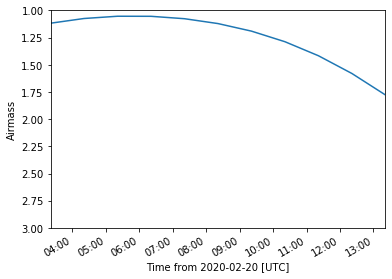

In [46]:
plot_airmass(my_target_one, this_room, my_time_grid);

### Better Plot

##### Make a target list

In [47]:
target_list = [my_target_one, my_target_two]

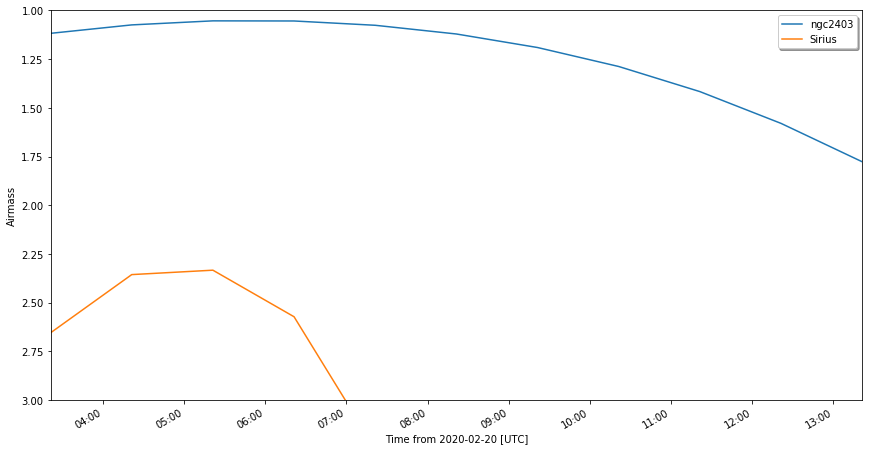

In [48]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6)

fig.tight_layout()

for my_object in target_list:
    ax = plot_airmass(my_object, this_room, my_time_grid)

ax.legend(loc=0,shadow=True);

---
### [There is lots of information available for your location](https://astroplan.readthedocs.io/en/latest/api/astroplan.Observer.html)


In [49]:
this_room.is_night(my_noon)

False

In [50]:
this_room.sun_altaz(my_noon)

<SkyCoord (AltAz: obstime=2458899.34956422, location=(-2300696.13625653, -3637728.46313361, 4691060.73294862) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    (180.0849511, 31.10176267, 1.478794e+11)>

In [51]:
this_room.moon_illumination(my_midnight)

0.10136165262307362

In [52]:
this_room.local_sidereal_time(my_midnight)

<Longitude 10.20916715 hourangle>